In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tabular_simple import TabularSimple
from generator import Generator
from discriminator import Discriminator
from rollout_max_ent import ROLLOUT
import tensorflow as tf
from gan_trainer import GanTrainer
from dataloader import Gen_Data_loader, Dis_dataloader

/zhome/30/0/70339/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/zhome/30/0/70339/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/zhome/30/0/70339/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/zhome/30/0/70339/.local/lib/python3.6/site-packages/tensorflow/python/frame

In [3]:
n_modes = 2
n_vocabulary = 4
vocab = range(n_vocabulary)
tabular_model = TabularSimple(4,n_vocabulary,n_modes)

<BarContainer object of 4 artists>

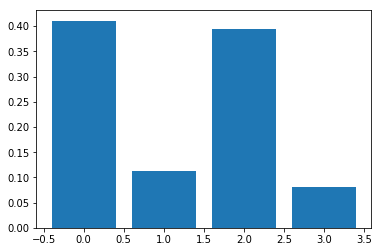

In [4]:
dist = tabular_model.table["10"]
plt.bar(vocab, dist)

In [5]:
size = 10000
samples = tabular_model.sample(size)

In [6]:
np.savetxt('save/real_data_tab.txt',samples,fmt='%d',delimiter=' ')

In [7]:
len(list(tabular_model.table.keys()))

85

In [8]:
tabular_model.ll(samples)

-1.2077784677031083

In [9]:
TabularSimple(4,n_vocabulary,n_modes).ll(samples)

-1.2077784677031083

In [10]:
#########################################################################################
#  Generator  Hyper-parameters
######################################################################################
EMB_DIM = 4 # embedding dimension
HIDDEN_DIM = 4 # hidden state dimension of lstm cell
SEQ_LENGTH = 4 # sequence length
START_TOKEN = 0
PRE_EPOCH_NUM = 120 # supervise (maximum likelihood estimation) epochs
SEED = 88
BATCH_SIZE = 128
vocab_size = 4

#########################################################################################
#  Discriminator  Hyper-parameters
#########################################################################################
dis_embedding_dim = 4
dis_filter_sizes = [1, 2, 3, 4]
#dis_num_filters = [200, 200, 200, 200]
dis_num_filters = [10, 10, 10, 10]
dis_dropout_keep_prob = 0.75
dis_l2_reg_lambda = 0.2
dis_batch_size = 128

#########################################################################################
#  Basic Training Parameters
#########################################################################################
TOTAL_BATCH = 200
positive_file = 'save/real_data_tab.txt'
negative_file = 'save/generator_sample_tab.txt'
negative_file_ent = 'save/generator_sample_tab_ent.txt'
#eval_file = 'save/eval_file_tab.txt'
generated_num = 10000
sequence_length = 4
g_lr = 0.01
generator = Generator(vocab_size, BATCH_SIZE, EMB_DIM, HIDDEN_DIM, SEQ_LENGTH, START_TOKEN,learning_rate=g_lr)
generator_ent = Generator(vocab_size, BATCH_SIZE, EMB_DIM, HIDDEN_DIM, SEQ_LENGTH, START_TOKEN,learning_rate=g_lr)

discriminator = Discriminator(sequence_length=sequence_length, num_classes=2, vocab_size=vocab_size, embedding_size=dis_embedding_dim, 
                            filter_sizes=dis_filter_sizes, num_filters=dis_num_filters, l2_reg_lambda=dis_l2_reg_lambda)
rollout = ROLLOUT(generator, 0.8)
rollout_ent = ROLLOUT(generator_ent, 0.8)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.random.categorical instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [11]:
gen_data_loader = Gen_Data_loader(BATCH_SIZE,SEQ_LENGTH)
gen_data_loader_ent = Gen_Data_loader(BATCH_SIZE,SEQ_LENGTH)
dis_data_loader = Dis_dataloader(BATCH_SIZE,SEQ_LENGTH)
gan_trainer = GanTrainer(generator,discriminator,rollout,gen_data_loader,dis_data_loader,
           tabular_model,'pretrain_notebook','advtrain_notebook',positive_file,negative_file,BATCH_SIZE)
gan_trainer_ent = GanTrainer(generator_ent,discriminator,rollout_ent,gen_data_loader_ent,dis_data_loader,
           tabular_model,'pretrain_notebook','advtrain_notebook',positive_file,negative_file_ent,BATCH_SIZE)

In [12]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [13]:
# run from saved checkpoint 
#saver = tf.train.Saver()
#tf.reset_default_graph()
#saver.restore(sess, 'model/pretrain_max_ent_tab.ckpt')
#saver.restore(sess, 'model/advtrain.ckpt')

In [14]:
sess.run(tf.global_variables_initializer())

In [15]:
saver = tf.train.Saver()

In [16]:
generated_num

10000

In [17]:
gan_trainer.pretrain(sess, 20, 20,3,
    saver,dis_dropout_keep_prob,generated_num)
gan_trainer_ent.pretrain(sess, 20, 20,3,
    saver,dis_dropout_keep_prob,generated_num)

Start pre-training...
pre-train epoch  0 test_loss  1.5461448313526345
pre-train epoch  5 test_loss  1.3282689683199427
pre-train epoch  10 test_loss  1.3279617285212446
pre-train epoch  15 test_loss  1.2550612212354764
Start pre-training discriminator...
pre-train entropy:  1.2380302
Start pre-training...
pre-train epoch  0 test_loss  1.5686908542468987
pre-train epoch  5 test_loss  1.2887272702999477
pre-train epoch  10 test_loss  1.2963328658692754
pre-train epoch  15 test_loss  1.3080919351348335
Start pre-training discriminator...
pre-train entropy:  1.201304


In [18]:
#EVEN WITH A VERY HIGH ENTROPY CONSTANT WE DON't see any major difference

In [19]:
for it in range(10000):
    for temp, gen, gan in zip([9999,.25],[generator,generator_ent],[gan_trainer, gan_trainer_ent]):
        test_loss, g_loss = gan.advtrain_gen(sess,1,64,temp)
        policy_ent = sess.run(gen.pretrain_loss,
                {gen.x: gen.generate(sess)})
        class_ = 1
        predictions = np.array([])
        for i in range(10):
            predictions = np.concatenate((predictions,sess.run(discriminator.ypred_for_auc, {discriminator.input_x: gen.generate(sess), discriminator.dropout_keep_prob: dis_dropout_keep_prob})[:,class_]))
        #self.writer.add_scalar('Loss/discrim_loss', disc_loss, total_batch)
        #print("discrim  --  min: {}, max: {}, ll: {}, loss: {}".format(min(predictions),max(predictions),np.mean(np.log(predictions)),disc_loss))
        if it % 10 == 0:
            print("GenT: {:.4f} -  test_loss: {:.4f}, g_loss: {:.4f}, pol_ent: {:.4f}, ll_disc: {:.4f}, maxp_disc: {:.4f}, minp_disc: {:.4f}"
                .format(temp, test_loss, g_loss,policy_ent,np.mean(np.log(predictions)),max(predictions),min(predictions)))
    

GenT: 9999.0000 -  test_loss: 1.2495, g_loss: -9.1001, pol_ent: 1.2398, ll_disc: -0.6900, maxp_disc: 0.6332, minp_disc: 0.3819
GenT: 0.2500 -  test_loss: 1.2927, g_loss: 5.5378, pol_ent: 1.2232, ll_disc: -0.6969, maxp_disc: 0.6151, minp_disc: 0.4020
GenT: 9999.0000 -  test_loss: 1.3739, g_loss: -72.7016, pol_ent: 1.2656, ll_disc: -0.6480, maxp_disc: 0.6325, minp_disc: 0.4180
GenT: 0.2500 -  test_loss: 1.3030, g_loss: -89.5767, pol_ent: 1.3091, ll_disc: -0.6667, maxp_disc: 0.6327, minp_disc: 0.3931
GenT: 9999.0000 -  test_loss: 1.4266, g_loss: -113.5382, pol_ent: 1.1991, ll_disc: -0.6286, maxp_disc: 0.6309, minp_disc: 0.4366
GenT: 0.2500 -  test_loss: 1.4141, g_loss: -131.7533, pol_ent: 1.1739, ll_disc: -0.6466, maxp_disc: 0.6437, minp_disc: 0.3966
GenT: 9999.0000 -  test_loss: 1.3501, g_loss: -125.0718, pol_ent: 1.0996, ll_disc: -0.6141, maxp_disc: 0.6432, minp_disc: 0.4211
GenT: 0.2500 -  test_loss: 1.4396, g_loss: -16.4328, pol_ent: 1.2069, ll_disc: -0.6344, maxp_disc: 0.6408, minp_d

GenT: 0.2500 -  test_loss: 1.7412, g_loss: 0.4291, pol_ent: 0.0507, ll_disc: -0.5008, maxp_disc: 0.6460, minp_disc: 0.4938
GenT: 9999.0000 -  test_loss: 1.7355, g_loss: -165.6342, pol_ent: 0.0003, ll_disc: -0.4998, maxp_disc: 0.6469, minp_disc: 0.5298
GenT: 0.2500 -  test_loss: 1.7412, g_loss: 0.5288, pol_ent: 0.0021, ll_disc: -0.4995, maxp_disc: 0.6458, minp_disc: 0.5300
GenT: 9999.0000 -  test_loss: 1.7412, g_loss: -0.0132, pol_ent: 0.0003, ll_disc: -0.5001, maxp_disc: 0.6455, minp_disc: 0.5210
GenT: 0.2500 -  test_loss: 1.7412, g_loss: 0.0597, pol_ent: 0.0160, ll_disc: -0.4996, maxp_disc: 0.6471, minp_disc: 0.4815
GenT: 9999.0000 -  test_loss: 1.7412, g_loss: -0.0147, pol_ent: 0.0003, ll_disc: -0.4988, maxp_disc: 0.6462, minp_disc: 0.5410
GenT: 0.2500 -  test_loss: 1.7355, g_loss: -79.3993, pol_ent: 0.0296, ll_disc: -0.4996, maxp_disc: 0.6458, minp_disc: 0.5435
GenT: 9999.0000 -  test_loss: 1.7412, g_loss: -0.0019, pol_ent: 0.0003, ll_disc: -0.4972, maxp_disc: 0.6457, minp_disc: 0.5

/zhome/30/0/70339/courses/music/coding/seqGAN/official/SeqGAN/rollout_max_ent.py:112: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards))/np.std(rewards)


InvalidArgumentError: Found Inf or NaN global norm. : Tensor had NaN values
	 [[node VerifyFinite_1/CheckNumerics (defined at /zhome/30/0/70339/courses/music/coding/seqGAN/official/SeqGAN/generator.py:123) ]]

Caused by op 'VerifyFinite_1/CheckNumerics', defined at:
  File "/appl/python/3.6.2/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/appl/python/3.6.2/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/appl/python/3.6.2/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/appl/python/3.6.2/lib/python3.6/asyncio/base_events.py", line 1426, in _run_once
    handle._run()
  File "/appl/python/3.6.2/lib/python3.6/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue
    yield self.process_one()
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-6805846cf019>", line 35, in <module>
    generator = Generator(vocab_size, BATCH_SIZE, EMB_DIM, HIDDEN_DIM, SEQ_LENGTH, START_TOKEN,learning_rate=g_lr)
  File "/zhome/30/0/70339/courses/music/coding/seqGAN/official/SeqGAN/generator.py", line 123, in __init__
    self.g_grad, _ = tf.clip_by_global_norm(tf.gradients(self.g_loss, self.g_params), self.grad_clip)
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/tensorflow/python/ops/clip_ops.py", line 271, in clip_by_global_norm
    "Found Inf or NaN global norm.")
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/tensorflow/python/ops/numerics.py", line 44, in verify_tensor_all_finite
    return verify_tensor_all_finite_v2(t, msg, name)
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/tensorflow/python/ops/numerics.py", line 62, in verify_tensor_all_finite_v2
    verify_input = array_ops.check_numerics(x, message=message)
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 919, in check_numerics
    "CheckNumerics", tensor=tensor, message=message, name=name)
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/zhome/30/0/70339/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Found Inf or NaN global norm. : Tensor had NaN values
	 [[node VerifyFinite_1/CheckNumerics (defined at /zhome/30/0/70339/courses/music/coding/seqGAN/official/SeqGAN/generator.py:123) ]]


In [ ]:
#ll is not affected too much by training

In [ ]:
x_t = tf.nn.embedding_lookup(generator.g_embeddings, [10]*128)
h_tm1 = generator.h0
h_t = generator.g_recurrent_unit(x_t, h_tm1)  # hidden_memory_tuple
o_t = generator.g_output_unit(h_t)  # batch x vocab , logits not prob
#log_prob = tf.log(tf.nn.softmax(o_t))
dist0 = sess.run(tf.nn.softmax(o_t))[0,:]

In [ ]:
plt.bar(vocab, dist0)

In [ ]:
x_t = tf.nn.embedding_lookup(generator_ent.g_embeddings, [10]*128)
h_tm1 = generator_ent.h0
h_t = generator_ent.g_recurrent_unit(x_t, h_tm1)  # hidden_memory_tuple
o_t = generator_ent.g_output_unit(h_t)  # batch x vocab , logits not prob
#log_prob = tf.log(tf.nn.softmax(o_t))
dist0_ent = sess.run(tf.nn.softmax(o_t))[0,:]

In [ ]:
plt.bar(vocab, dist0_ent)

In [ ]:
plt.bar(vocab,tabular_model.table["10"])